In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string

# VEST MT 2018
---

## VEST Documentation

### Election Results

#### Sources
Election results from Montana Secretary of State (https://sosmt.gov/elections/results/)

### Shapefiles

#### Sources
Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program. 

### Processing
The A/B subdivisions of Precinct 16 and Precinct 33 in Lewis and Clark were added based on county precinct maps.

### Candidates
G18USSRROS - Matt Rosendale (Republican Party)  
G18USSDTES - Jon Tester (Democratic Party)  
G18USSLBRE - Rick Breckenridge (Libertarian Party)  

G18HALRGIA - Greg Gianforte (Republican Party)  
G18HALDWIL - Kathleen Williams (Democratic Party)  
G18HALLSWA - Elinor Swanson (Libertarian Party)  

G18CSCRGRE - Bowen Greenwood (Republican Party)  
G18CSCDREN - Rex Renk (Democratic Party)  
G18CSCLROO - Roger Roots (Libertarian Party)  

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_mt_18 = gp.read_file("./raw-from-source/VEST/mt_2018/mt_2018.shp")

In [3]:
vest_mt_18.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

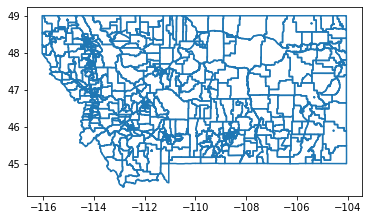

In [4]:
vest_mt_18.boundary.plot()

In [5]:
vest_mt_18.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G18USSRROS',
       'G18USSDTES', 'G18USSLBRE', 'G18HALRGIA', 'G18HALDWIL', 'G18HALLSWA',
       'G18CSCRGRE', 'G18CSCDREN', 'G18CSCLROO', 'geometry'],
      dtype='object')

In [6]:
vest_mt_18.head(5)

,STATEFP10,COUNTYFP10,COUNTY,NAME,SOSPRECINC,G18USSRROS,G18USSDTES,G18USSLBRE,G18HALRGIA,G18HALDWIL,G18HALLSWA,G18CSCRGRE,G18CSCDREN,G18CSCLROO,geometry
0,30,063,Missoula,Bonner 89,BONNER 89,74,105,1,83,96,3,82,84,6,"POLYGON ((-113.91270 46.88124, -113.91193 46.8..."
1,30,063,Missoula,Bonner 92,BONNER 92,526,771,37,562,725,49,535,644,87,"POLYGON ((-113.84047 47.00811, -113.82150 47.0..."
2,30,063,Missoula,C S Porter 98,CSPORTER 98,486,1151,63,535,1094,70,517,946,154,"POLYGON ((-114.03203 46.86054, -114.03200 46.8..."
3,30,063,Missoula,Chief Charlo 90,CHIEF CHARLO 90,418,883,24,475,819,29,457,724,77,"POLYGON ((-114.02484 46.82333, -114.02484 46.8..."
4,30,063,Missoula,Clinton 89,CLINTON 89,230,220,15,245,200,19,241,169,41,"POLYGON ((-113.82366 46.83264, -113.82288 46.8..."


### Create a FIPs dictionary for MT

In [7]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Montana"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
mt_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Created `2018-GeneralPrecinct-by-Precinct_Votes.csv` from `2018-GeneralPrecinct-by-Precinct_Votes.xlsx` by opening in Excel, removing the first header row, and saving as a csv. No file modifications were made. 

In [8]:
#Load in clean SOS file
elections_2018 = pd.read_csv("./raw-from-source/MT_SOS/2018-GeneralPrecinct-by-Precinct_Votes.csv")

In [9]:
elections_2018.shape

(14595, 8)

In [10]:
elections_2018.head()

,CountyName,PrecinctName,RaceName,PartyCode,Votes,NameOnBallot,HouseDistrict,SenateDistrict
0,Beaverhead,PRECINCT 01,UNITED STATES SENATOR,REP,159,MATT ROSENDALE,House District 72,Senate District 36
1,Beaverhead,PRECINCT 02,UNITED STATES SENATOR,REP,452,MATT ROSENDALE,House District 72,Senate District 36
2,Beaverhead,PRECINCT 03,UNITED STATES SENATOR,REP,471,MATT ROSENDALE,House District 72,Senate District 36
3,Beaverhead,PRECINCT 04,UNITED STATES SENATOR,REP,109,MATT ROSENDALE,House District 72,Senate District 36
4,Beaverhead,PRECINCT 05,UNITED STATES SENATOR,REP,104,MATT ROSENDALE,House District 72,Senate District 36


### Prepare to Pivot Election Results

In [11]:
#Filter down to the offices we need
office_list = ['UNITED STATES SENATOR','UNITED STATES REPRESENTATIVE','CLERK OF THE SUPREME COURT']
elections_2018 = elections_2018[elections_2018["RaceName"].isin(office_list)]

In [12]:
#Create a list of candidates we need based on VEST's file
candidate_list = ["Matt Rosendale","Jon Tester","Rick Breckenridge",
                  "Greg Gianforte","Kathleen Williams","Elinor Swanson",
                  "Bowen Greenwood","Rex Renk","Roger Roots"]

#Filter the file down to just those candidates
elections_2018=elections_2018[elections_2018["NameOnBallot"].isin([x.upper() for x in candidate_list])]

In [13]:
elections_2018["NameOnBallot"].unique()

array(['MATT ROSENDALE', 'JON TESTER', 'RICK BRECKENRIDGE',
       'GREG GIANFORTE', 'KATHLEEN WILLIAMS', 'ELINOR SWANSON',
       'BOWEN GREENWOOD', 'REX RENK', 'ROGER ROOTS'], dtype=object)

In [14]:
# Change column names to match the county fips dict
elections_2018.loc[elections_2018['CountyName'] == 'Lewis & Clark', 'CountyName'] = 'Lewis and Clark'

#Map to the correct FIP
elections_2018["county"]=elections_2018["CountyName"].map(mt_fips_dict).fillna(elections_2018["CountyName"])

#Print out the FIPS to make sure they all are in the correct format
elections_2018["county"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '057', '055', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111'], dtype=object)

In [15]:
print(elections_2018["CountyName"].nunique())
print(len(mt_fips_dict))

56
56


In [16]:
#Clean up the precinct column by striping the white space
elections_2018["PrecinctName"]=elections_2018["PrecinctName"].str.strip()

#Create a column to pivot one by concatenating the FIPS with the precinct
elections_2018["pivot_col"]=elections_2018["county"]+elections_2018["PrecinctName"]

### Pivot Election Results

In [17]:
#Run the pivot
pivoted_2018 = pd.pivot_table(elections_2018,values=["Votes"],index=["pivot_col"],columns=["NameOnBallot"],aggfunc=sum)

#Fill NA values w/ 0
pivoted_2018 = pivoted_2018.fillna(0)

#Clean the columns
pivoted_2018.reset_index(drop=False,inplace=True)
pivoted_2018.columns = pivoted_2018.columns.droplevel(0)

In [18]:
#Print the df to get a sense for it
pivoted_2018.head()

NameOnBallot,,BOWEN GREENWOOD,ELINOR SWANSON,GREG GIANFORTE,JON TESTER,KATHLEEN WILLIAMS,MATT ROSENDALE,REX RENK,RICK BRECKENRIDGE,ROGER ROOTS
0,001PRECINCT 01,174,9,180,251,231,159,197,12,26
1,001PRECINCT 02,463,21,494,233,199,452,167,28,38
2,001PRECINCT 03,489,16,509,246,219,471,185,22,30
3,001PRECINCT 04,118,6,117,50,44,109,31,9,10
4,001PRECINCT 05,102,1,106,28,27,104,20,1,5


In [19]:
pivoted_2018.columns

Index(['', 'BOWEN GREENWOOD', 'ELINOR SWANSON', 'GREG GIANFORTE', 'JON TESTER',
       'KATHLEEN WILLIAMS', 'MATT ROSENDALE', 'REX RENK', 'RICK BRECKENRIDGE',
       'ROGER ROOTS'],
      dtype='object', name='NameOnBallot')

In [20]:
#Rename the columns
pivoted_2018.columns = ["join_col",'G18CSCRGRE','G18HALLSWA','G18HALRGIA','G18USSDTES',
                        'G18HALDWIL','G18USSRROS','G18CSCDREN','G18USSLBRE','G18CSCLROO']

In [21]:
#Add in a column with the state, county and precinct name
pivoted_2018["STATEFP10"]="30"
pivoted_2018["COUNTYFP10"]=pivoted_2018["join_col"].str[0:3]
pivoted_2018["NAME"]=pivoted_2018["join_col"].str[3:]

In [22]:
pivoted_2018.head()

,join_col,G18CSCRGRE,G18HALLSWA,G18HALRGIA,G18USSDTES,G18HALDWIL,G18USSRROS,G18CSCDREN,G18USSLBRE,G18CSCLROO,STATEFP10,COUNTYFP10,NAME
0,001PRECINCT 01,174,9,180,251,231,159,197,12,26,30,001,PRECINCT 01
1,001PRECINCT 02,463,21,494,233,199,452,167,28,38,30,001,PRECINCT 02
2,001PRECINCT 03,489,16,509,246,219,471,185,22,30,30,001,PRECINCT 03
3,001PRECINCT 04,118,6,117,50,44,109,31,9,10,30,001,PRECINCT 04
4,001PRECINCT 05,102,1,106,28,27,104,20,1,5,30,001,PRECINCT 05


In [23]:
#Take a look at VEST's file
vest_mt_18.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G18USSRROS',
       'G18USSDTES', 'G18USSLBRE', 'G18HALRGIA', 'G18HALDWIL', 'G18HALLSWA',
       'G18CSCRGRE', 'G18CSCDREN', 'G18CSCLROO', 'geometry'],
      dtype='object')

In [24]:
#Reorder the election result df's columns to match VEST's
pivoted_2018 = pivoted_2018[['STATEFP10', 'COUNTYFP10', 'NAME','G18USSRROS',
       'G18USSDTES', 'G18USSLBRE', 'G18HALRGIA', 'G18HALDWIL', 'G18HALLSWA',
       'G18CSCRGRE', 'G18CSCDREN', 'G18CSCLROO',"join_col"]]

#Create a join column in the VEST file
vest_mt_18["join_col"]=vest_mt_18['COUNTYFP10']+vest_mt_18['SOSPRECINC']

In [25]:
pivoted_2018.shape

(669, 13)

## Compare Election Results Totals

### Compare Total Votes

In [26]:
races = [x for x in vest_mt_18.columns if 'G18' in x]
races

['G18USSRROS',
 'G18USSDTES',
 'G18USSLBRE',
 'G18HALRGIA',
 'G18HALDWIL',
 'G18HALLSWA',
 'G18CSCRGRE',
 'G18CSCDREN',
 'G18CSCLROO']

In [27]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_mt_18[i])
    sum_var_2 += np.sum(pivoted_2018[i])
print(sum_var_1)
print(sum_var_2)

1489106
1489106


### Compare Race Totals

In [28]:
for race in races:
    diff_val = sum(vest_mt_18[race])-sum(pivoted_2018[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL - " + str(sum(vest_mt_18[race])))

G18USSRROS: EQUAL - 235963
G18USSDTES: EQUAL - 253876
G18USSLBRE: EQUAL - 14545
G18HALRGIA: EQUAL - 256661
G18HALDWIL: EQUAL - 233284
G18HALLSWA: EQUAL - 14476
G18CSCRGRE: EQUAL - 247130
G18CSCDREN: EQUAL - 204411
G18CSCLROO: EQUAL - 28760


### Compare County Totals

In [29]:
diff_counties=[]
for i in races:
    diff = pivoted_2018.groupby(["COUNTYFP10"]).sum()[i]-vest_mt_18.groupby(["COUNTYFP10"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(race, diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(race + ' county totals: EQUAL')

G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL


### Check for Zero Vote Precincts in VEST

In [30]:
vest_mt_18[vest_mt_18['G18USSRROS'] == 0]

,STATEFP10,COUNTYFP10,COUNTY,NAME,SOSPRECINC,G18USSRROS,G18USSDTES,G18USSLBRE,G18HALRGIA,G18HALDWIL,G18HALLSWA,G18CSCRGRE,G18CSCDREN,G18CSCLROO,geometry,join_col
390,30,029,Flathead,NA,None,0,0,0,0,0,0,0,0,0,"POLYGON ((-113.79807 48.22350, -113.79620 48.2...",NaN
391,30,029,Flathead,NA,None,0,0,0,0,0,0,0,0,0,"POLYGON ((-113.79240 48.38270, -113.79256 48.3...",NaN
670,30,047,Lake,NA,None,0,0,0,0,0,0,0,0,0,"POLYGON ((-114.03396 47.95345, -114.03355 47.9...",NaN


### Attempt to join the dataframes

In [31]:
join_attempt_one = pd.merge(vest_mt_18,pivoted_2018,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

both          665
left_only       7
right_only      4
Name: _merge, dtype: int64


In [32]:
join_attempt_one.columns

Index(['STATEFP10_x', 'COUNTYFP10_x', 'COUNTY', 'NAME_x', 'SOSPRECINC',
       'G18USSRROS_x', 'G18USSDTES_x', 'G18USSLBRE_x', 'G18HALRGIA_x',
       'G18HALDWIL_x', 'G18HALLSWA_x', 'G18CSCRGRE_x', 'G18CSCDREN_x',
       'G18CSCLROO_x', 'geometry', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y',
       'NAME_y', 'G18USSRROS_y', 'G18USSDTES_y', 'G18USSLBRE_y',
       'G18HALRGIA_y', 'G18HALDWIL_y', 'G18HALLSWA_y', 'G18CSCRGRE_y',
       'G18CSCDREN_y', 'G18CSCLROO_y', '_merge'],
      dtype='object')

In [33]:
join_attempt_one[join_attempt_one['_merge'] != 'both'][['COUNTY','NAME_x','SOSPRECINC','NAME_y','join_col']]

,COUNTY,NAME_x,SOSPRECINC,NAME_y,join_col
190,Cascade,P22B,P22B,NaN,013P22B
390,Flathead,NA,None,NaN,NaN
391,Flathead,NA,None,NaN,NaN
392,Lake,NA,None,NaN,NaN
484,Sanders,9-DIXON - HD14,9-DIXON-HD14,NaN,0899-DIXON-HD14
665,Lake,PAB1,PAB 1 HD93,NaN,047PAB 1 HD93
667,Lake,PAB2,PAB 2 HD15,NaN,047PAB 2 HD15
672,NaN,NaN,NaN,P22B.,013P22B.
673,NaN,NaN,NaN,PAB 1_HD93,047PAB 1_HD93
674,NaN,NaN,NaN,PAB 2_HD15,047PAB 2_HD15


### Change names in VEST file

In [34]:
#Define a name change dictionary, this was found by checking votes and then manually verifying each change
source_vest_names_dict = {'0899-Dixon-HD14':'0899-DIXON-HD14',
                          '047PAB 1_HD93':'047PAB 1 HD93',
                          '047PAB 2_HD15':'047PAB 2 HD15',
                          '013P22B.':'013P22B'}

#Use the dictionary to change the names
pivoted_2018["join_col"]=pivoted_2018["join_col"].map(source_vest_names_dict).fillna(pivoted_2018["join_col"])


### Join Attempt 2

In [35]:
join_attempt_two = pd.merge(vest_mt_18,pivoted_2018,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

both          669
left_only       3
right_only      0
Name: _merge, dtype: int64


In [36]:
join_attempt_two[join_attempt_two['_merge'] != 'both'][['COUNTY','NAME_x','SOSPRECINC','NAME_y','join_col']]

,COUNTY,NAME_x,SOSPRECINC,NAME_y,join_col
390,Flathead,NA,None,NaN,NaN
391,Flathead,NA,None,NaN,NaN
392,Lake,NA,None,NaN,NaN


In [37]:
print(join_attempt_two[join_attempt_two["_merge"]!="both"])

    STATEFP10_x COUNTYFP10_x    COUNTY NAME_x SOSPRECINC  G18USSRROS_x  \
390          30          029  Flathead     NA       None             0   
391          30          029  Flathead     NA       None             0   
392          30          047      Lake     NA       None             0   

     G18USSDTES_x  G18USSLBRE_x  G18HALRGIA_x  G18HALDWIL_x  ...  \
390             0             0             0             0  ...   
391             0             0             0             0  ...   
392             0             0             0             0  ...   

     G18USSRROS_y  G18USSDTES_y  G18USSLBRE_y  G18HALRGIA_y G18HALDWIL_y  \
390           NaN           NaN           NaN           NaN          NaN   
391           NaN           NaN           NaN           NaN          NaN   
392           NaN           NaN           NaN           NaN          NaN   

    G18HALLSWA_y G18CSCRGRE_y G18CSCDREN_y G18CSCLROO_y     _merge  
390          NaN          NaN          NaN          NaN 

Only the 3 zero vote precincts left. 

### Compare Precinct Votes

In [38]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [67]:
validater_row(join_attempt_two[join_attempt_two["_merge"]=="both"].sort_values("join_col"),races)


There are  669  total rows
0  of these rows have election result differences
669  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]


# Precinct Shapefile

## Load in the shapefiles

> Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program.



### Shp from SOS

> Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program.

Link to the shapefile from the SOS: https://mslservices.mt.gov/Geographic_Information/Data/DataList/datalist_Details.aspx?did=%7bdbd29997-21d8-4af1-9d87-5c5134775995%7d
Navigate to "Download Data", select "MontanaVotingPrecincts_shp.zip". 

Confirming whether this file is the same as the TIGER/Line file. 

In [40]:
mt_shp = gp.read_file('./raw-from-source/MT_SOS/MontanaVotingPrecincts_shp/VotingPrecincts.shp')

In [41]:
mt_shp.head(1)

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,Liberty,48,30,051,2010 CENSUS GIS DATA,2012-07-31,4362,1 PREC,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52..."


In [42]:
print(mt_shp.shape)
print(vest_mt_18.shape)

(666, 17)
(672, 16)


In [43]:
mt_shp.crs

<Projected CRS: EPSG:32100>
Name: NAD83 / Montana
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Montana - counties of Beaverhead; Big Horn; Blaine; Broadwater; Carbon; Carter; Cascade; Chouteau; Custer; Daniels; Dawson; Deer Lodge; Fallon; Fergus; Flathead; Gallatin; Garfield; Glacier; Golden Valley; Granite; Hill; Jefferson; Judith Basin; Lake; Lewis and Clark; Liberty; Lincoln; Madison; McCone; Meagher; Mineral; Missoula; Musselshell; Park; Petroleum; Phillips; Pondera; Powder River; Powell; Prairie; Ravalli; Richland; Roosevelt; Rosebud; Sanders; Sheridan; Silver Bow; Stillwater; Sweet Grass; Teton; Toole; Treasure; Valley; Wheatland; Wibaux; Yellowstone.
- bounds: (-116.07, 44.35, -104.04, 49.01)
Coordinate Operation:
- name: SPCS83 Montana zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [44]:
vest_mt_18 = vest_mt_18.to_crs(epsg=32100)

<AxesSubplot:>

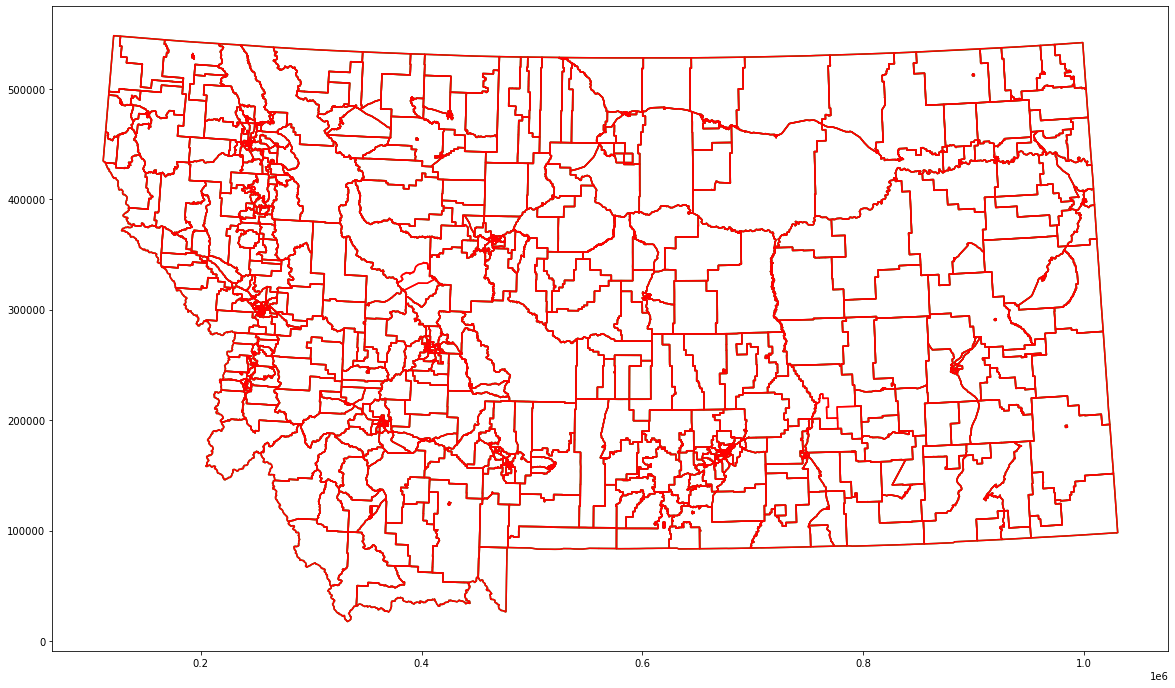

In [45]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = mt_shp.boundary.plot(figsize=(20,20),color="green")
vest_mt_18.boundary.plot(figsize=(20,20),ax=ax,color="red")

In [46]:
#Add a join column to the source shapefile
mt_shp["join_col"]=mt_shp['COUNTYFP10']+mt_shp['NAME']
mt_shp

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry,join_col
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,Liberty,48,30,051,2010 CENSUS GIS DATA,2012-07-31,4362,1 PREC,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52...",051#1 Precinct - West
1,000001,1-HERON-HD13,13,7,HERON COMMUNITY CENTER,Sanders,35,30,089,COUNTY GIS DATA,2018-10-23,3750,#1,45,89108.059261,2.808293e+08,"POLYGON ((114102.250 461041.840, 114155.020 46...",0891-HERON-HD13
2,000001,1 WESTBY,34,17,WESTBY COMMUNITY HALL,Sheridan,34,30,091,DIGITIZED FROM COUNTY MAP,2019-06-21,4518,1_PREC,46,152033.377796,7.430864e+08,"POLYGON ((998562.006 541713.323, 998580.694 54...",0911 WESTBY
3,000001,COLUMBUS PRECINCT 1,57,29,STILLWATER PAVILLION,Stillwater,32,30,095,COUNTY GIS DATA,2019-08-01,2337,PREC_1,48,210565.225728,9.073550e+08,"POLYGON ((616112.063 176124.484, 616516.128 17...",095COLUMBUS PRECINCT 1
4,000001,FORT BENTON 1,27,14,FORT BENTON ELEMENTARY,Chouteau,19,30,015,DIGITIZED FROM COUNTY MAP,2018-09-18,1596,PCT_01,08,109711.564255,4.525434e+08,"POLYGON ((518671.300 403468.700, 518742.000 40...",015FORT BENTON 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,091RsE,RATTLSNK 91E,91,46,RATTLESNAKE SCHOOL,Missoula,4,30,063,COUNTY GIS DATA,2017-12-08,0101,RTSK91E,32,38610.036938,4.614562e+07,"MULTIPOLYGON (((269038.527 311285.230, 269069....",063RATTLSNK 91E
662,091RsW,RATTLSNK 91W,91,46,RATTLESNAKE SCHOOL,Missoula,4,30,063,COUNTY GIS DATA,2017-12-08,0102,RTSK91W,32,63995.590427,8.861097e+07,"POLYGON ((260921.486 320735.884, 261328.405 32...",063RATTLSNK 91W
663,098CSP,CSPORTER 98,98,49,C S PORTER SCHOOL,Missoula,4,30,063,COUNTY GIS DATA,2017-12-08,0072,CSPTR98,32,8405.353040,2.378015e+06,"POLYGON ((254663.592 300078.247, 254780.890 30...",063CSPORTER 98
664,100SJE,ST JOSEPH 100E,100,50,ST JOSEPH SCHOOL,Missoula,4,30,063,COUNTY GIS DATA,2017-12-08,0111,STJ100E,32,5803.940669,1.297146e+06,"POLYGON ((257366.239 299946.499, 257445.832 29...",063ST JOSEPH 100E


## **Attempt to join dataframes**

In [47]:
join_attempt_shape1 = pd.merge(mt_shp,vest_mt_18,how="outer",on="join_col",indicator=True)
print(join_attempt_shape1["_merge"].value_counts())
join_attempt_shape1.columns

both          653
right_only     19
left_only      13
Name: _merge, dtype: int64


Index(['NUMBER', 'NAME_x', 'HOUSE', 'SENATE', 'POLLINGPLA', 'COUNTY_x',
       'COUNTYCODE', 'STATEFP10_x', 'COUNTYFP10_x', 'SOURCE', 'LAST_UPDAT',
       'PRECINCT_I', 'PRECINCT_C', 'COUNTY_ID', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry_x', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'COUNTY_y',
       'NAME_y', 'SOSPRECINC', 'G18USSRROS', 'G18USSDTES', 'G18USSLBRE',
       'G18HALRGIA', 'G18HALDWIL', 'G18HALLSWA', 'G18CSCRGRE', 'G18CSCDREN',
       'G18CSCLROO', 'geometry_y', '_merge'],
      dtype='object')

In [48]:
join_attempt_shape1[join_attempt_shape1['_merge'] != 'both'][['NAME_x','SOSPRECINC','NAME_y','join_col']]

,NAME_x,SOSPRECINC,NAME_y,join_col
22,Precinct 1,NaN,NaN,103Precinct 1
159,CITY OF TROY,NaN,NaN,053CITY OF TROY
200,9-Dixon-HD14,NaN,NaN,0899-Dixon-HD14
437,NA,NaN,NaN,029NA
438,NA,NaN,NaN,029NA
439,NA,NaN,NaN,047NA
440,VIRGINIA CITY,NaN,NaN,057VIRGINIA CITY
441,ALDER,NaN,NaN,057ALDER
460,P22B.,NaN,NaN,013P22B.
535,JEFF ISLAND,NaN,NaN,057JEFF ISLAND


## **Change names in join column**

In [49]:
source_vest_shp_dict = {'053CITY OF TROY':'053TROY COMBINED',
                        '0899-Dixon-HD14':'0899-DIXON-HD14',
                        '057VIRGINIA CITY':'057VIRGINIA CITY - WARD 1',
                        '057ALDER':'057ALDER - WARD 2',
                        '013P22B.':'013P22B','057HARRISON':'057HARRISON - WARD 2',
                        '047PAB 1_HD93':'047PAB 1 HD93',
                        '047PAB 2_HD15':'047PAB 2 HD15',
                        '057JEFF ISLAND':'057JEFFERSON ISLAND - WARD 1'}
mt_shp["join_col"]=mt_shp["join_col"].map(source_vest_shp_dict).fillna(mt_shp["join_col"])

## **Join attempt 2**

In [50]:
join_attempt_shape2 = pd.merge(mt_shp,vest_mt_18,how="outer",on="join_col",indicator=True)
print(join_attempt_shape2["_merge"].value_counts())
join_attempt_shape2

both          662
right_only     10
left_only       4
Name: _merge, dtype: int64


,NUMBER,NAME_x,HOUSE,SENATE,POLLINGPLA,COUNTY_x,COUNTYCODE,STATEFP10_x,COUNTYFP10_x,SOURCE,...,G18USSDTES,G18USSLBRE,G18HALRGIA,G18HALDWIL,G18HALLSWA,G18CSCRGRE,G18CSCDREN,G18CSCLROO,geometry_y,_merge
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,Liberty,48,30,051,2010 CENSUS GIS DATA,...,89.0,10.0,239.0,60.0,6.0,215.0,55.0,9.0,"POLYGON ((489630.964 519814.997, 489630.462 51...",both
1,000001,1-HERON-HD13,13,7,HERON COMMUNITY CENTER,Sanders,35,30,089,COUNTY GIS DATA,...,95.0,12.0,230.0,87.0,16.0,236.0,74.0,21.0,"POLYGON ((115169.730 460414.060, 115204.910 46...",both
2,000001,1 WESTBY,34,17,WESTBY COMMUNITY HALL,Sheridan,34,30,091,DIGITIZED FROM COUNTY MAP,...,54.0,3.0,132.0,45.0,0.0,122.0,41.0,4.0,"POLYGON ((999335.574 530475.784, 999345.135 53...",both
3,000001,COLUMBUS PRECINCT 1,57,29,STILLWATER PAVILLION,Stillwater,32,30,095,COUNTY GIS DATA,...,594.0,72.0,1524.0,521.0,77.0,1506.0,424.0,92.0,"POLYGON ((617343.856 174110.822, 617347.363 17...",both
4,000001,FORT BENTON 1,27,14,FORT BENTON ELEMENTARY,Chouteau,19,30,015,DIGITIZED FROM COUNTY MAP,...,231.0,13.0,246.0,201.0,14.0,242.0,164.0,26.0,"POLYGON ((519910.938 402975.954, 520262.615 40...",both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((261696.070 421316.430, 261720.650 42...",right_only
672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104.0,4.0,60.0,97.0,2.0,63.0,87.0,7.0,"POLYGON ((408983.247 261761.244, 409032.237 26...",right_only
673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,429.0,11.0,242.0,409.0,11.0,226.0,378.0,27.0,"POLYGON ((408534.251 261923.785, 408535.419 26...",right_only
674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,2.0,52.0,9.0,4.0,49.0,6.0,3.0,"POLYGON ((407524.226 337360.840, 407523.776 33...",right_only


In [51]:
join_attempt_shape2[join_attempt_shape2['_merge'] != 'both'][['NAME_x','SOSPRECINC','NAME_y','join_col']]

,NAME_x,SOSPRECINC,NAME_y,join_col
22,Precinct 1,NaN,NaN,103Precinct 1
437,NA,NaN,NaN,029NA
438,NA,NaN,NaN,029NA
439,NA,NaN,NaN,047NA
666,NaN,PRECINCT # 3,Precinct 3,103PRECINCT # 3
667,NaN,PRECINCT # 4,Precinct 4,103PRECINCT # 4
668,NaN,PRECINCT # 6,Precinct 6,103PRECINCT # 6
669,NaN,None,NA,NaN
670,NaN,None,NA,NaN
671,NaN,None,NA,NaN


### Write something here explaining the below

### County Shapefile

> The A/B subdivisions of Precinct 16 and Precinct 33 in Lewis and Clark were added based on county precinct maps.

Found these maps here that are PDFs but we can use to compare: 
https://www.lccountymt.gov/it/gis-maps/completed-maps/voting-precincts.html. No shapefiles available. 

**Examine unmatched precincts**

(672, 16)

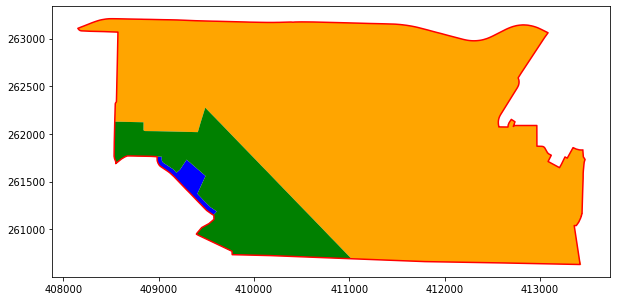

In [52]:
ax = mt_shp[mt_shp['join_col'] =='049PCT 16'].boundary.plot(color="red",figsize=(10,10))
vest_mt_18[vest_mt_18['join_col'] == '049PCT 16'].plot(ax = ax, color='orange')
vest_mt_18[vest_mt_18['join_col'] == '049PCT 16A'].plot(ax=ax, color='blue')
vest_mt_18[vest_mt_18['join_col'] == '049PCT 16B'].plot(ax=ax, color='green')
vest_mt_18.shape

**Merge 16, 16A, and 16B in VEST file**

<AxesSubplot:>

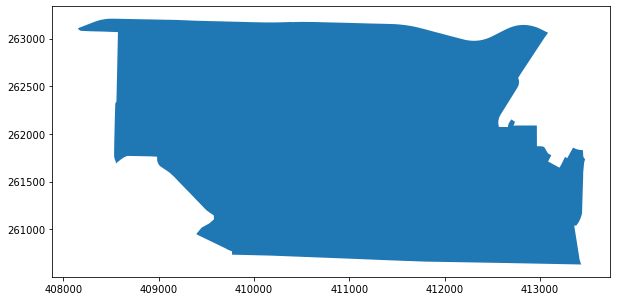

In [53]:
#Merge precinct 16A, and 16B into 16
prec2combine = [vest_mt_18.loc[vest_mt_18["join_col"]=="049PCT 16"],vest_mt_18.loc[vest_mt_18["join_col"]=="049PCT 16A"],vest_mt_18.loc[vest_mt_18["join_col"]=="049PCT 16B"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_18.loc[vest_mt_18["join_col"]=="049PCT 16","geometry"]=new_fort.unary_union
vest_mt_18 = vest_mt_18[vest_mt_18["join_col"]!="049PCT 16A"]
vest_mt_18 = vest_mt_18[vest_mt_18["join_col"]!="049PCT 16B"]
vest_mt_18[vest_mt_18['join_col'] =='049PCT 16'].plot(figsize=(10,10))

<AxesSubplot:>

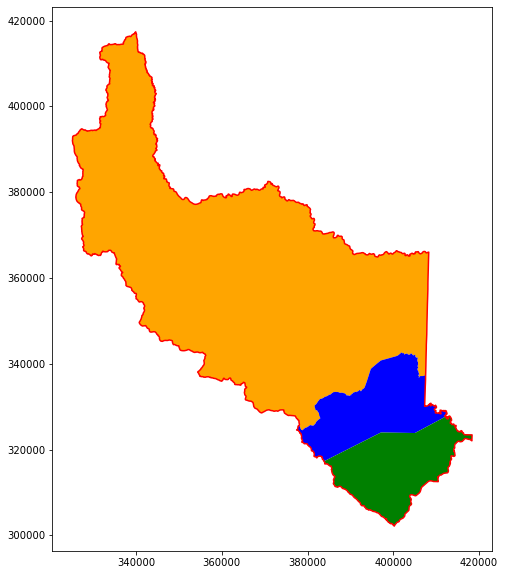

In [54]:
ax = mt_shp[mt_shp['join_col'] =='049PCT 33'].boundary.plot(color="red",figsize=(10,10))
vest_mt_18[vest_mt_18['join_col'] == '049PCT 33'].plot(ax = ax, color='orange')
vest_mt_18[vest_mt_18['join_col'] == '049PCT 33A'].plot(ax=ax, color='blue')
vest_mt_18[vest_mt_18['join_col'] == '049PCT 33B'].plot(ax=ax, color='green')

<AxesSubplot:>

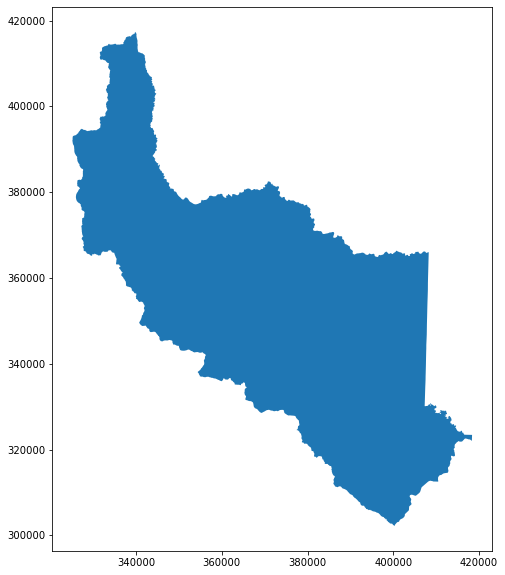

In [55]:
#Merge precinct 33A, and 33B into 33
prec2combine = [vest_mt_18.loc[vest_mt_18["join_col"]=="049PCT 33"],vest_mt_18.loc[vest_mt_18["join_col"]=="049PCT 33A"],vest_mt_18.loc[vest_mt_18["join_col"]=="049PCT 33B"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_18.loc[vest_mt_18["join_col"]=="049PCT 33","geometry"]=new_fort.unary_union
vest_mt_18 = vest_mt_18[vest_mt_18["join_col"]!="049PCT 33A"]
vest_mt_18 = vest_mt_18[vest_mt_18["join_col"]!="049PCT 33B"]
vest_mt_18[vest_mt_18['join_col'] =='049PCT 33'].plot(figsize=(10,10))

(668, 16)

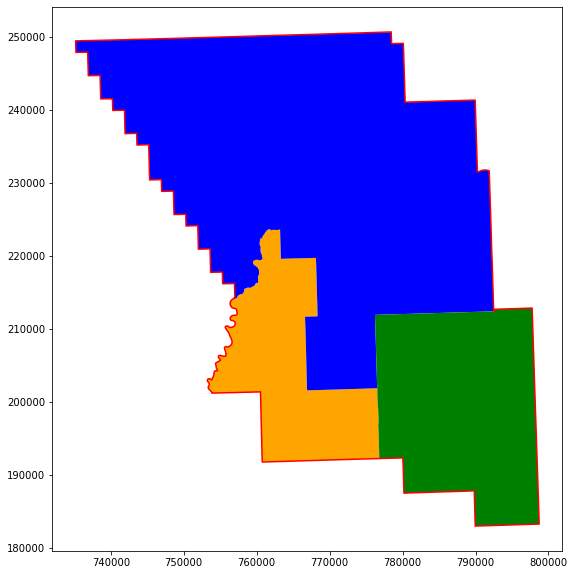

In [56]:
ax = mt_shp[mt_shp['join_col'] =='103Precinct 1'].boundary.plot(color="red",figsize=(10,10))
vest_mt_18[vest_mt_18['join_col'] == '103PRECINCT # 3'].plot(ax=ax, color='orange')
vest_mt_18[vest_mt_18['join_col'] == '103PRECINCT # 4'].plot(ax=ax, color='blue')
vest_mt_18[vest_mt_18['join_col'] == '103PRECINCT # 6'].plot(ax=ax, color='green')
vest_mt_18.shape

<AxesSubplot:>

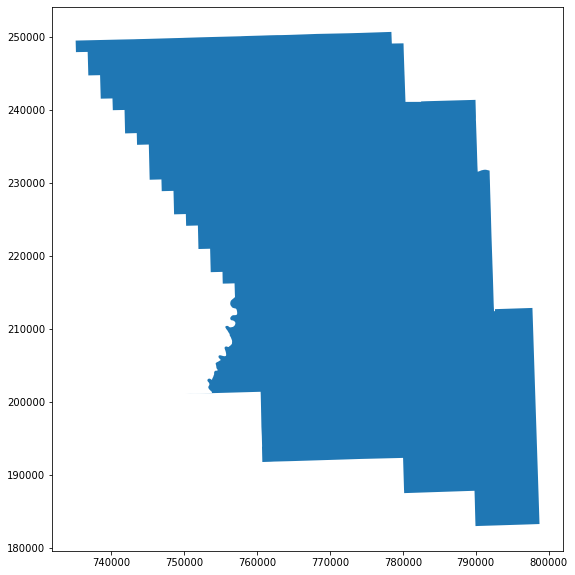

In [57]:
#Merge precinct 3, 4, and 6 into 1
prec2combine = [vest_mt_18.loc[vest_mt_18["join_col"]=="103PRECINCT # 3"],vest_mt_18.loc[vest_mt_18["join_col"]=="103PRECINCT # 4"],vest_mt_18.loc[vest_mt_18["join_col"]=="103PRECINCT # 6"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
vest_mt_18.loc[vest_mt_18["join_col"]=="103PRECINCT # 3","join_col"]='103Precinct 1'
vest_mt_18.loc[vest_mt_18["join_col"]=="103Precinct 1","geometry"]=new_fort.unary_union
vest_mt_18 = vest_mt_18[vest_mt_18["join_col"]!="103PRECINCT # 4"]
vest_mt_18 = vest_mt_18[vest_mt_18["join_col"]!="103PRECINCT # 6"]
vest_mt_18[vest_mt_18['join_col'] =='103Precinct 1'].plot(figsize=(10,10))

In [58]:
#Add names to join_col for zero vote precincts
vest_mt_18.at[390,'join_col'] = 'FLATHEAD-1'
vest_mt_18.at[391,'join_col'] = 'FLATHEAD-2'
vest_mt_18.at[670,'join_col'] = 'LAKE-1'

In [59]:
mt_shp.at[437,'join_col'] = 'FLATHEAD-1'
mt_shp.at[438,'join_col'] = 'LAKE-1'
mt_shp.at[439,'join_col'] = 'FLATHEAD-2'

## **Final Merge**

In [60]:
final_merge = pd.merge(mt_shp,vest_mt_18,how="outer",on="join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          666
left_only       0
right_only      0
Name: final_merge, dtype: int64

# **Validate Geometry**

In [61]:
print(final_merge.columns)

Index(['NUMBER', 'NAME_x', 'HOUSE', 'SENATE', 'POLLINGPLA', 'COUNTY_x',
       'COUNTYCODE', 'STATEFP10_x', 'COUNTYFP10_x', 'SOURCE', 'LAST_UPDAT',
       'PRECINCT_I', 'PRECINCT_C', 'COUNTY_ID', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry_x', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'COUNTY_y',
       'NAME_y', 'SOSPRECINC', 'G18USSRROS', 'G18USSDTES', 'G18USSLBRE',
       'G18HALRGIA', 'G18HALDWIL', 'G18HALLSWA', 'G18CSCRGRE', 'G18CSCDREN',
       'G18CSCLROO', 'geometry_y', 'final_merge'],
      dtype='object')


In [62]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    634
True      32
dtype: int64


1) For PRECINCT #1 ALZADA difference in area is 0.1017384806458782
2) For PRECINCT 01 difference in area is 0.20917505437252104
3) For Precinct 1 difference in area is 0.26515436623746336
4) For RYEGATE difference in area is 0.7463098171338802
5) For LAVINA difference in area is 0.5339707749682859
6) For PRECINCT #2 difference in area is 0.5987685620210799
7) For 3-TROUT CREEK-HD13 difference in area is 0.11690597704982707
8) For PRECINCT #3 difference in area is 1.1446534155966117
9) For PRECINCT 3 difference in area is 0.46687047691902117
10) For PRECINCT 3 difference in area is 0.8519442742559487
11) For PRECINCT 04 difference in area is 0.23138583799461396
12) For PRECINCT 4 difference in area is 0.37080951711547266
13) For PRECINCT NO. 4 difference in area is 0.4879000269364206
14) For PRECINCT04 difference in area is 0.10982698750962608
15) For 5 PLENTYWOOD RURAL WEST difference in area is 0.14987000280783466
16) For PCT 05 difference in area is 0.11441039797470395
17) For PRECIN

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


22) For PRECINCT 07 difference in area is 0.2725025489190609
23) For PRECINCT 7 difference in area is 0.1320937210005508
24) For PRECINCT 7 difference in area is 0.31508017324170584
25) For PCT 08 difference in area is 0.15688516990135382
26) For SHEFFIELD MOON difference in area is 0.1483875669101755
27) For RAPELJE PRECINCT 9 difference in area is 0.19838520005359828
28) For S-H SCHOOL difference in area is 0.12303606403383817
29) For NYE PRECINCT 10 difference in area is 0.15433979306783852
30) For PRECINCT #10 difference in area is 0.25869856654737944
31) For PRECINCT 10 difference in area is 0.31732014484024706
32) For PRECINCT 11 difference in area is 0.1133834228836705
33) For PRECINCT11 difference in area is 0.15530078996374538
34) For SPRING CREEK SCH difference in area is 0.11207436672471434
35) For PRECINCT12 difference in area is 0.1217959331486635
36) For PRECINCT #14 RURAL EKALAKA difference in area is 0.1317056938505663
37) For PRECINCT 14 difference in area is 0.3768205

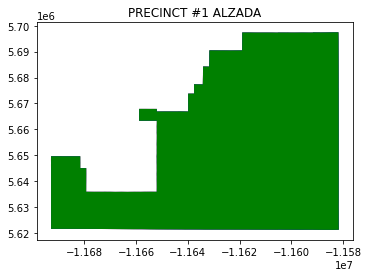

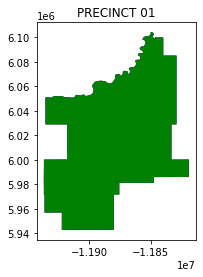

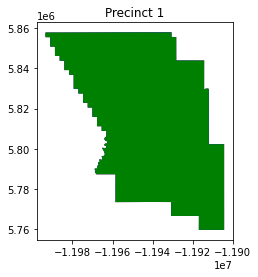

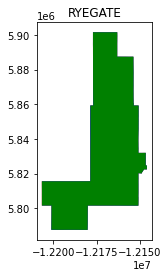

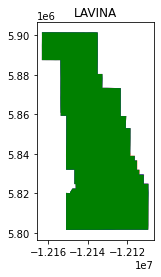

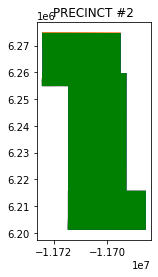

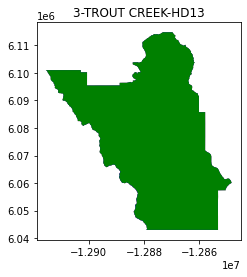

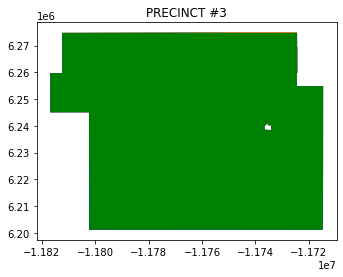

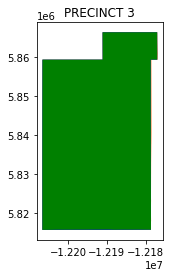

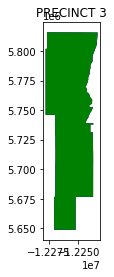

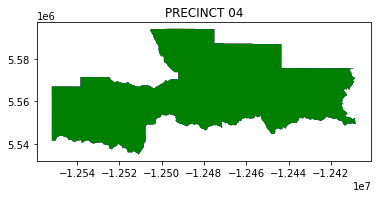

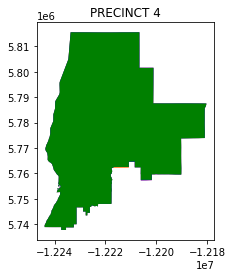

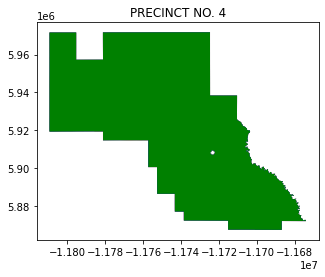

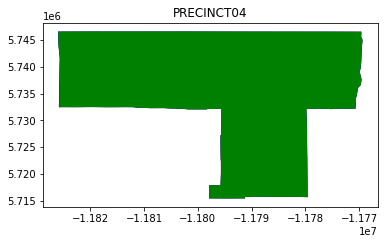

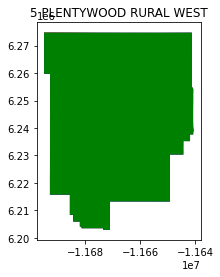

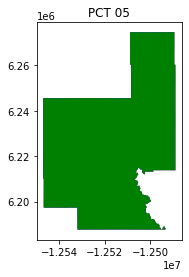

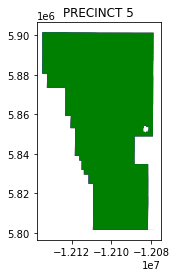

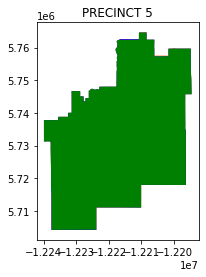

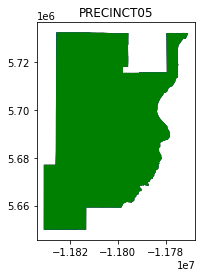

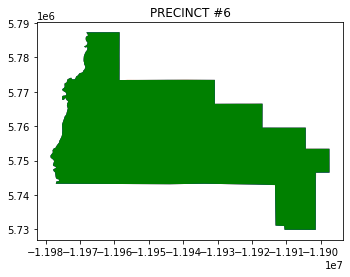

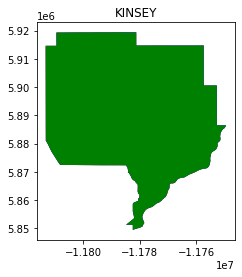

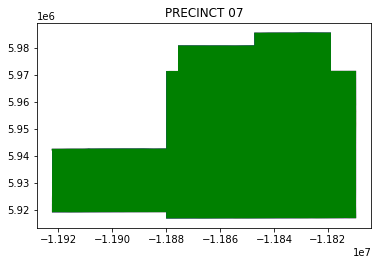

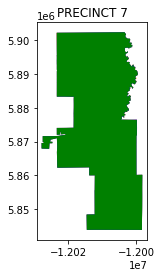

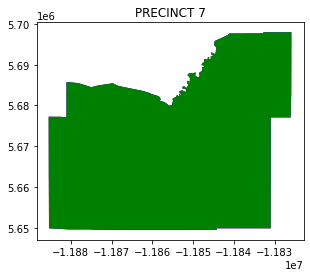

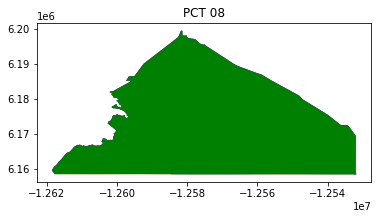

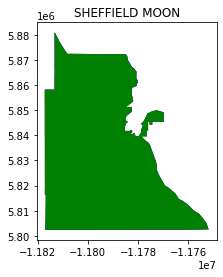

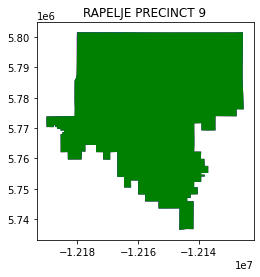

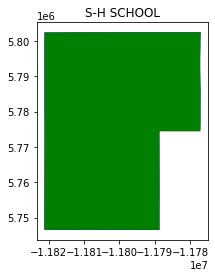

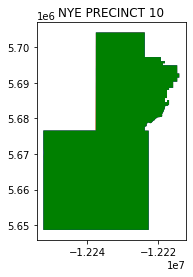

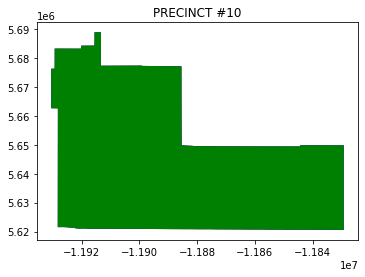

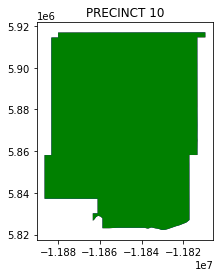

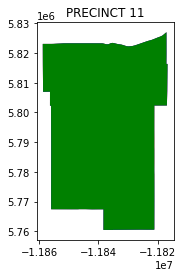

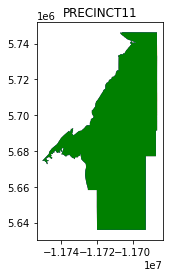

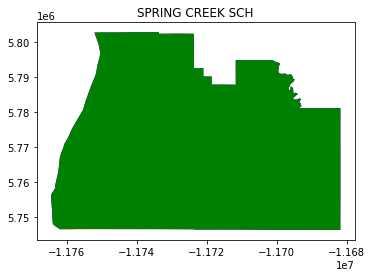

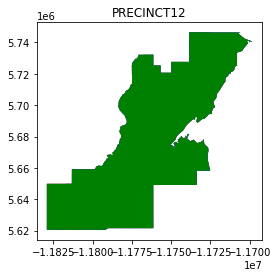

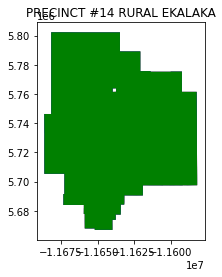

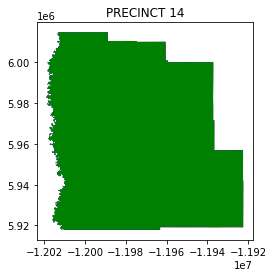

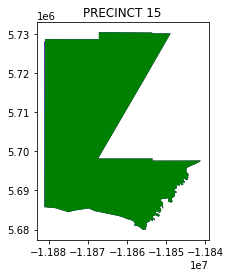

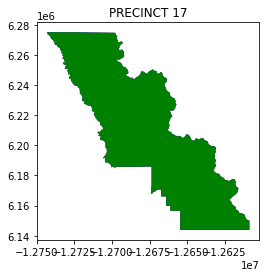

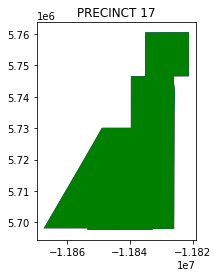

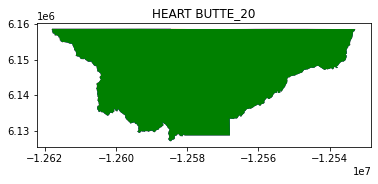

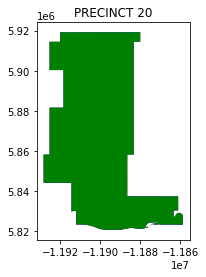

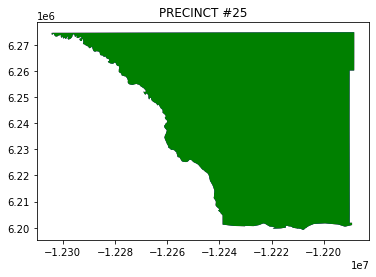

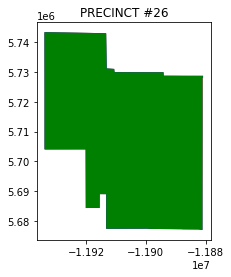

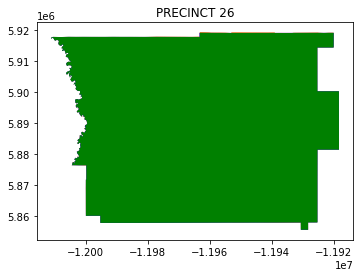

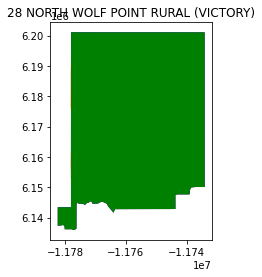

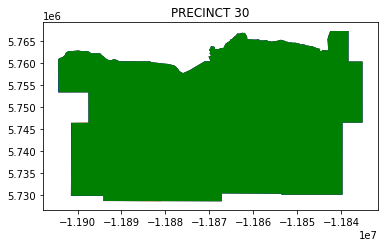

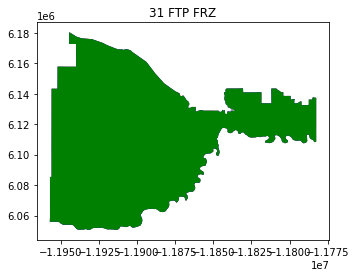

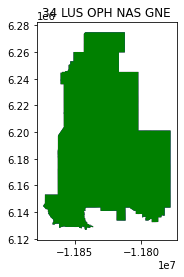

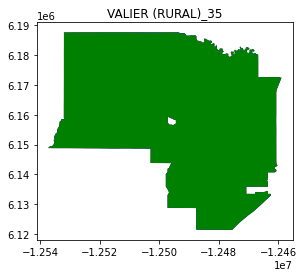

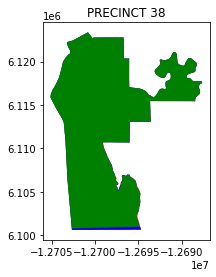

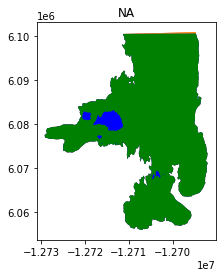

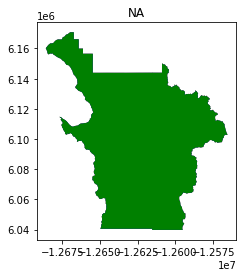

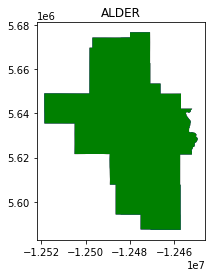

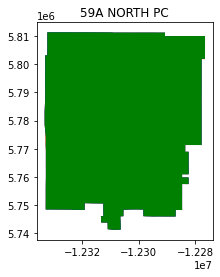

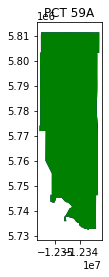

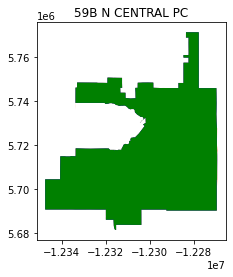

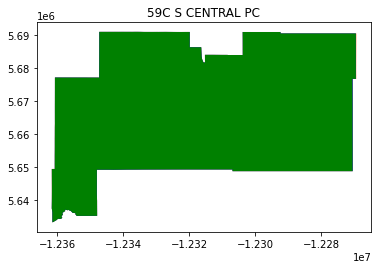

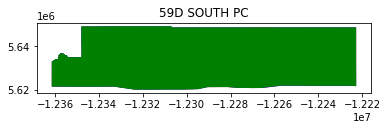

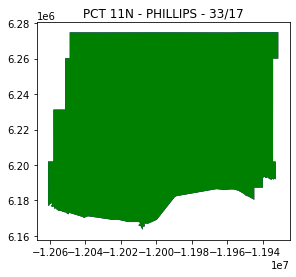

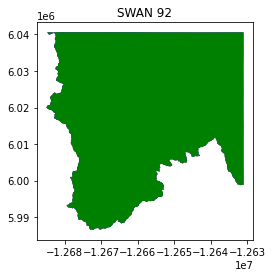

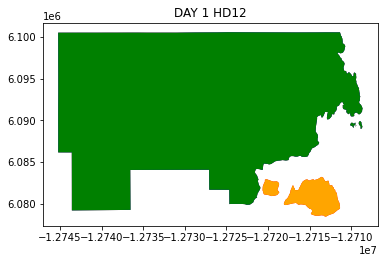

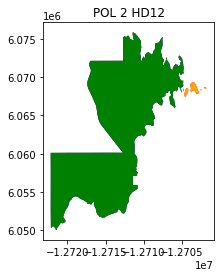

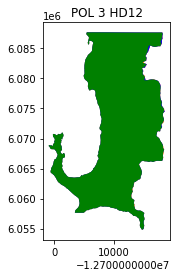

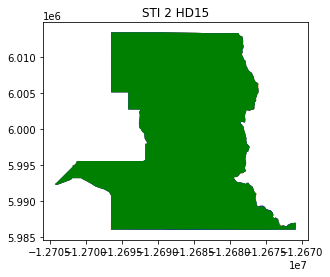

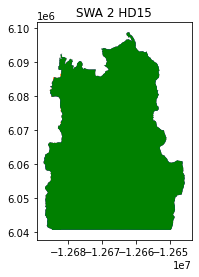

In [63]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,1]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [64]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(666, 1)
12 precincts w/ a difference of 0 km^2
588 precincts w/ a difference between 0 and .1 km^2
58 precincts w/ a difference between .1 and .5 km^2
5 precincts w/ a difference between .5 and 1 km^2
1 precincts w/ a difference between 1 and 2 km^2
2 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


## **Look into Flathead Lake differences**

### It appears that VEST assigned islands in Flathead lake to precincts "DAY 1 HD12" and "POL 2 HD12" which caused the largest discrepencies between the SOS shapefile and VEST's

<AxesSubplot:>

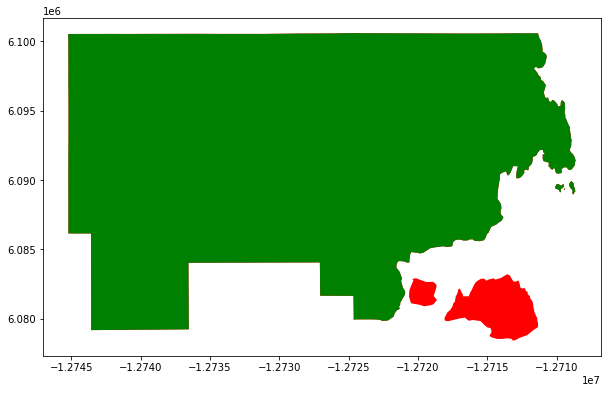

In [65]:
mt_shp = mt_shp.to_crs(3857)
vest_mt_18 = vest_mt_18.to_crs(3857)
ax = vest_mt_18[vest_mt_18['SOSPRECINC'] == 'DAY 1 HD12'].plot(figsize=(10,10),color="red")
mt_shp[mt_shp['NAME'] == 'DAY 1 HD12'].plot(figsize=(10,10),ax=ax,color="green")

<AxesSubplot:>

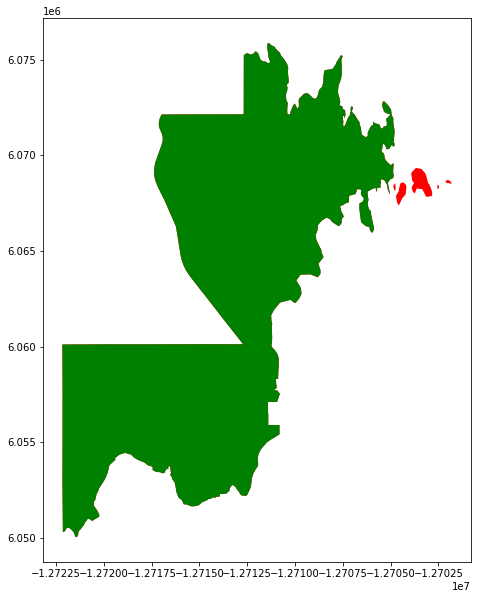

In [66]:
ax = vest_mt_18[vest_mt_18['SOSPRECINC'] == 'POL 2 HD12'].plot(figsize=(10,10),color="red")
mt_shp[mt_shp['NAME'] == 'POL 2 HD12'].plot(figsize=(10,10),ax=ax,color="green")